In [1]:
from pathlib import Path

import pandas as pd

DATA_PATH = Path("data/Expenses-2025.11.csv")
EXPECTED_COLUMNS = [
    "Posted Date",
    "Payee",
    "Amount",
    "ABS Amount",
    "Source",
    "Bas-Lux",
    "Category",
]

df = pd.read_csv(
    DATA_PATH,
    encoding="utf-8-sig",
    thousands=",",
)
df["Posted Date"] = pd.to_datetime(df["Posted Date"].str.strip(), format="%m/%d/%y")
df.columns = df.columns.str.strip()

missing_columns = sorted(set(EXPECTED_COLUMNS) - set(df.columns))
unexpected_columns = sorted(set(df.columns) - set(EXPECTED_COLUMNS))

if missing_columns or unexpected_columns:
    raise ValueError(
        "Column mismatch detected.\n"
        f"Missing: {missing_columns or 'None'}\n"
        f"Unexpected: {unexpected_columns or 'None'}"
    )

expenses_df = df[~df["Category"].isin(["Transfer", "credit card payment", "0"])].copy()

Category,Auto,Bank Fees,Boat,Cash,Charitable contributions,Clothing,Credit Card Payment,Dining,Enrichment,Extracirricular,...,R&R,SYC,Subscriptions / Digital,Travel,Utilities,Van,boat,clothing,groceries,hardware technology
month,,,,,,,,,,,,,,,,,,,,,
2025-08,1543.75,124.62,415.36,1802.60,101.0,2955.32,0.0,3306.24,967.82,178.3,...,0.0,199.11,302.14,16466.51,1274.12,870.14,96.90,348.43,0.00,610.98
2025-09,703.04,75.74,0.00,1357.74,0.0,208.04,0.0,2342.76,738.83,0.0,...,0.0,77.24,288.12,5460.20,291.33,173.99,48.45,145.26,88.68,107.25
2025-10,289.53,5964.82,0.00,0.00,0.0,424.68,0.0,2052.41,5043.44,0.0,...,0.0,70.00,488.78,4273.63,1290.90,5.00,0.00,29.84,112.19,356.65
2025-11,411.92,3746.34,0.00,0.00,0.0,0.00,0.0,1146.16,3959.01,0.0,...,0.0,70.00,84.01,8.15,1073.10,5.00,0.00,25.00,0.00,14.39


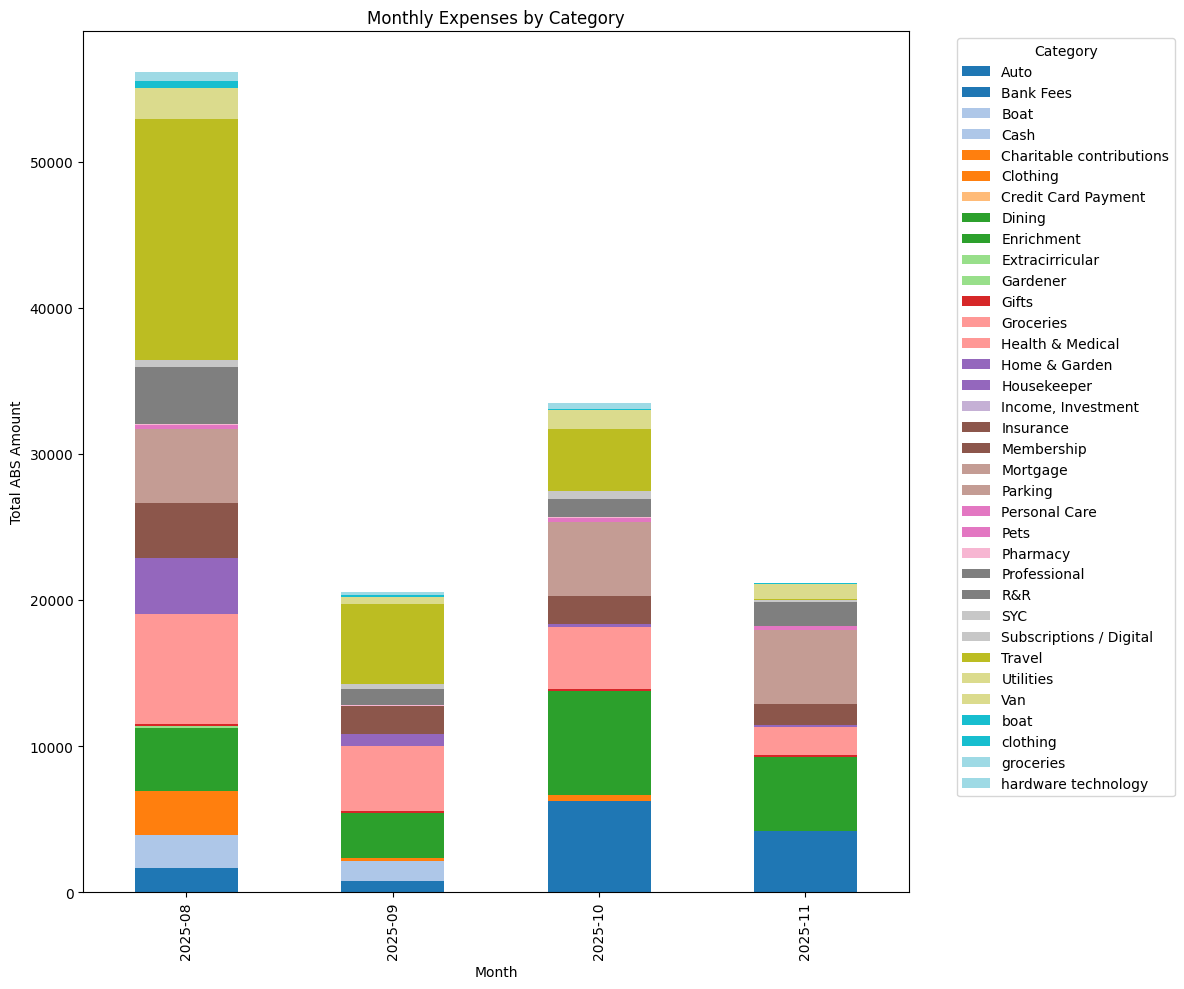

In [3]:
import matplotlib.pyplot as plt
from IPython.display import display

monthly_category = (
    expenses_df.assign(month=df["Posted Date"].dt.to_period("M"))
    .groupby(["month", "Category"], dropna=False)["ABS Amount"]
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

# remove any categories that have less than $100 total expenses in a month
monthly_category = monthly_category.loc[
    :, monthly_category.sum() >= 100
] 

# show only the last 4 months of data
monthly_category = monthly_category.tail(4)

ax = monthly_category.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 10),
    colormap="tab20",
)
ax.set_title("Monthly Expenses by Category")
ax.set_xlabel("Month")
ax.set_ylabel("Total ABS Amount")
ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

monthly_category


In [9]:
import plotly.express as px
from IPython.display import HTML

# Build the same dataset used for the Matplotlib stacked bar chart
plotly_data = (
    monthly_category.reset_index()
    .melt(id_vars='month', var_name='Category', value_name='ABS Amount')
)
plotly_data['month'] = plotly_data['month'].astype(str)

fig = px.bar(
    plotly_data,
    x='month',
    y='ABS Amount',
    color='Category',
    labels={'month': 'Month'},
    title='Monthly Expenses by Category (Interactive)',
)
fig.update_layout(barmode='stack', height=800, width=1200, legend_title='Category')

HTML(fig.to_html(include_plotlyjs='cdn', full_html=False))
